Consider the following synthetic data

In [152]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
%matplotlib inline

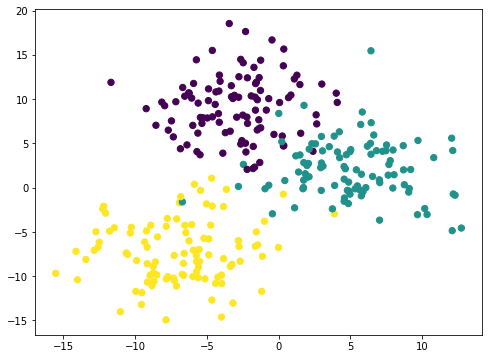

In [153]:
X, y = make_blobs(n_samples = 300, centers =3, cluster_std=3.5, random_state = 42)

plt.figure(figsize=(8, 6))
ax = plt.subplot(111)
ax.scatter(X[:,0], X[:,1], c=y, s=40, cmap='viridis')
plt.show()

We seperate it into two parts: training data and testing data

In [154]:
from sklearn.model_selection import train_test_split

unlabelpre = 0.4

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= unlabelpre, random_state=0)

 We will use the labeled data $(X_{train}, y_{train})$ and the unlabeled data $X_{test}$ to classify the data. That is, we will treat it as a semi-supervised learning problems without using the labels of the testing data $y_{test}$
 
 1. Please use self training K-means method to predict the labels of unlabeled data $X_{test}$ through the following steps:
     + For the labeled data $(X_{train}, y_{train})$, compute the centroid (mean) of each group.
     + Find the pseudo-labels of each unlabeled data according to K-means, that is, assign the label according to the closest centroid.
     + Update the centroid of each cluster by using all the labels and pseudo-labels.
     + Use the updated centroids to assign new pseudo-lables for the unlabled data. Do not update the true labels of the labeled data.
     + Repeat the precess until convergence.
 
 2. We need the following outputs for the final result obtained in 1.
     + The centroid (mean) and variance matrix of each cluster.
     + The percentage of points in each cluster.
     + The prediction accuracy by comparing the predicted labels and the true labels $y_{test}$ of the testing data.
     + Plot all the points by using colors to disstinguish the clusters and marker styles to distinguish the labeled points and unlabeled points.
     
3. Use semi-supervised GMM method with 3 classes to predict the labels of the unlabeled data $X_{test}$ with the following instructions:
    + Use the means, variance matrices, and the percentage obtained in 2 as the initial values.
    + Run the iterations until convergence.
    + Compute $\gamma_{j,l}$ the probability of each unlabeled points $x_{j}$ in each cluster $l$ and assign the lablels corresponding to the largest probability.
    + Compute the prediction accuracy by comparing the predicted labels and the true labels $y_{test}$ of the testing data.
    + Plot all the points by using colors to distinguish the clusters and marker styles to distinguish the labeled points and unlabeled points.


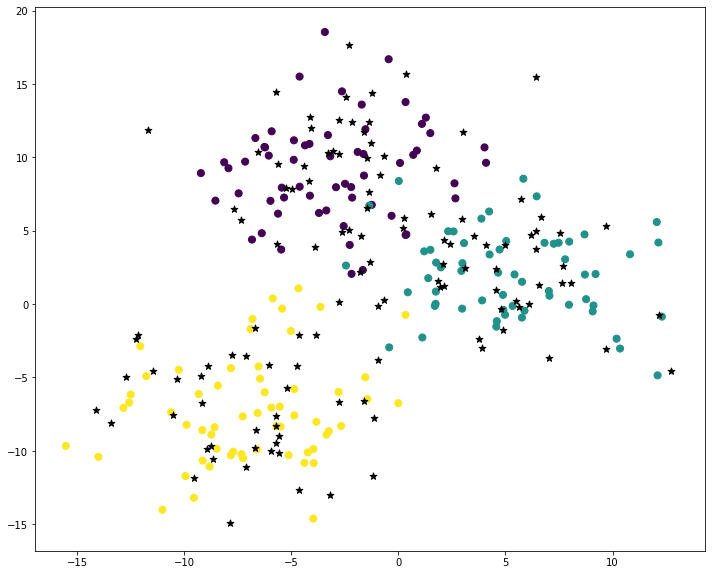

In [155]:
plt.figure(figsize=(12, 10))
ax = plt.subplot(111)
ax.scatter(X_train[:,0], X_train[:,1], c=y_train, s=50, cmap='viridis')
ax.scatter(X_test[:,0], X_test[:,1], c='k', marker='*', s=50)
plt.show()

### K-means Algorithm
+ Use labels $(1, 0, \cdots, 0), (0,1, \cdots, 0), (0, \cdots, 1)$ to denote the groups 1, 2, $\cdots$, K
+ Choose a random centriod $c_{k}$ to each cluster $C_{K}, 1\leq k \leq K$
+ Repeat 
     + Assign the label of each $x_{j}$ according to its closest centroids 
         + $y_{j} = argmin_{1\leq k \leq K} \ d(x_{j}, c_{k})-th \ column \ of \ I_{K}, 1\leq j \leq N$
         , where $I_K$ is the $K \times K$ identity matrix.
     + Update the centroids
         + $c_{k} = \frac{\sum_{j=1}^{N}y_{j,k}x_{j}}{\sum_{j=1}^{N}y_{j,k}}$
     + until the centroids do not change.

### Self Training Algorithm
+ Train $f$ from the labeled data $(x_{j}, y_{j}), 1\leq j \leq L$
+ Pseduo Labeling: Use the trained function to predict a label for some unlabeled data x
+ Retrain the model with pseduo and labeled data together
+ Repeat step 2 and 3 until convergence

### GMM : EM Algorithm
+ Initilization: give initial values for $\mu_{l}, \sum_{l}$, and $\pi_{l}$, for $1\leq l \leq K$.
+ Repeat until convergence 
    + (E-step) For given $\mu$ and $\sum$, estimate the probability of each training point $x_{j}$ in each cluster $l$:
        + $\gamma_{j,l} =  \frac{\pi_{l}\mathcal{N}(x_{j}|\mu_l, \sum_{l})}{\sum_{k=1}^{K}\pi_{k}\mathcal{N}(x_j| \mu_k, \sum_k)}$, $L+1 \leq j \leq N$
        + $\gamma_{j,l} = y_{j,l}$, $1\leq j \leq L$
    + (M-step) For given $\gamma$, update the changes in each cluster
        + $N_{l} = \sum_{j=1}^{N}\gamma_{j,l}$, and $\pi_{l} = \frac{N_l}{N}, 1\leq l \leq K$
    
    and use MLE to estimate the unknown parameters
        + $\mu_{l} = \frac{\sum_{j=1}^{N}\gamma_{j,l}x_{j}}{N_{l}}$
        + $\sum_{l} = \frac{\sum_{j=1}^{N}\gamma_{j,l}(x_{j}-\mu_l)^{T}(x_{j}-\mu_l)}{N_l}$
+ Convergence Ctiterion: Use either the likelihood or the parameters
    + likehood: $\sum_{j=1}^{N}\ln \left(\sum_{k=1}^{K}\pi_k \mathcal{N}\left(x_{j}|\mu_k, \sum_k \right) \right)$
    + parameters: $\pi, \mu, \sum$
      

In [156]:
import numpy as np
from numpy import linalg as LA
from scipy.stats import multivariate_normal

In [157]:
class Semi_Supervised():
    
    def __init__(self, cluster, dim):
        self.cluster = cluster
        self.dim = dim
    
    def OldLabel_to_newLabel(self, y_train):
        class_num = self.cluster
        data_dim = self.dim
        
        # convert old_label to new label
        new_label = np.zeros([len(y_train),class_num])
        for i in range(len(y_train)):
            if y_train[i] == 0:
                new_label[i,:] = np.eye(class_num)[0,:]
            elif y_train[i] == 1:
                new_label[i,:] = np.eye(class_num)[1,:]
            else:
                new_label[i,:] = np.eye(class_num)[2,:]
        return new_label
    
    def Centriods(self, X_train, y_train):
        """
        Compute centriods of the labeled data
        
        Parameters
        ---------
        X_train: (N x D) array of data, each row is a sample with D-dimension
        y_train: (N x 1) array of data, the label of X_train
        
        Returns:
        Ctrd: (Class_num x D) array of data, each column is the centriods of a class
        """
        
        class_num = self.cluster
        data_dim = self.dim
        
        Ctrd = np.zeros([class_num, data_dim])
        # Compute the centriods
        for j in range(class_num):
            Ctrd[j,:] = np.dot(y_train[:,j].T, X_train)/sum(y_train[:,j])
            
        return Ctrd
    
         
    def Kmeans_predict(self, X_test, Ctrd):
        """
        Predict the label of unlabeled data
        
        Parameters
        ----------
        X_test: (N x D) array of data, each row is a sample with D-dimension
        Ctrd: (class_num x D) array of data, each row is the centriods of a class
        
        Returns:
        Pred_label: (N x class_num) array of data, each row is the label if X_test
        """
        
        class_num = self.cluster
        data_dim = self.dim
        
        # predict label
        Pred_label = np.zeros([len(X_test), class_num])
        for i in range(len(X_test)):
            k = np.argmin(LA.norm(X_test[i,:]-Ctrd, axis=1))
            Pred_label[i,:] = np.eye(class_num)[k,:]
        
        return Pred_label
    
    def Gmm_Likelihood(self, X, pi, mu, sigma):
        """
        Compute the likelihood function of Gaussian Mixture model 
        
        Parameters
        ----------
        X: (N x d) array of data, each row is a sample d-dimension data
        pi: (K x 1) array of data, each row is the percentage of each cluster
        mu: (K x d) array of data, each row is the mean of ecah cluster
        sigma: ( [d x d] x K), K block data, each block is the covariance matrix of each cluster
        
        Returns
        -------
        Fun: a number, the value of likelihood function 
        """
        class_num = self.cluster
        data_dim = self.dim
        
        Gamma = np.zeros([len(X), class_num])
        for l in range(class_num):
            Gamma[:,l] = pi[l]*multivariate_normal.pdf(x=X, mean=mu[l], cov=sigma[l], allow_singular=True)
        
        Fun = np.log(np.sum(Gamma, axis=1))
        
        return np.sum(Fun, axis=0)
    
    def Semi_GmmTrain(self, X_train, y_train, X_test, pi, mu, sigma):
        """
        Train the parameter percentage pi, mean mu, and covariance matrix of GMM for each cluster
        
        Parameters
        ----------
        X_train: (L x d) array of data (labeled data ), each row is a sample d-dimension data
        y_train: (L x 1) array of data, each row is the label of labeled data
        X_test: (N-L x d) array of data (unlabeled data), each row is a sa,ple d-dimension data
        pi: (K x 1) array of data, each row is the percentage of each cluster
        mu: (K x d) array of data, each row is the mean of ecah cluster
        sigma: (K x [d x d]), K block data, each block is the covariance matrix of each cluster
        
        Returns
        -------
        ite: the number of iteration 
        pi: (K x 1) array of data, each row is the percentage of each cluster
        mu: (K x d) array of data, each row is the mean of ecah cluster
        sigma: (K x [d x d]), K block data, each block is the covariance matrix of each cluster
        Fun_vals: the Fun value in each step
        """
        class_num = self.cluster
        data_dim = self.dim
        
        eps = 0
        
        Fun = Semi.Gmm_Likelihood(X_train, pi, mu, sigma)
        new_label = Semi.OldLabel_to_newLabel(y_train)
         
        Gamma_unlabel = np.zeros([len(X_test), class_num])
        
        Fun_vals = []
        ite = 0
        error = 1
        
        while error > 1e-5:
            # (E-step)
            for l in range(class_num):
                Gamma_unlabel[:,l] = pi[l]*multivariate_normal.pdf(x=X_test, mean=mu[l], cov=sigma[l], allow_singular=True)
            for j in range(len(X_test)):
                Gamma_unlabel[j,:] /= np.sum(Gamma_unlabel[j,:]) 
            
            # update the unlabel Gamma
            Gamma = np.block([[new_label], [Gamma_unlabel]])
            # print(np.sum(Gamma, axis=1))

           
            # (M-step)
            # update pi, mu, and sigma
            X = np.block([[X_train],[X_test]])
            cov_k = np.zeros((X.shape[1], X.shape[1]))
            for l in range(class_num):
                pi[l] = np.sum(Gamma[:,l])/len(X)
                mu[l] = np.sum(Gamma[:,l].reshape([len(X),1]) * X, axis=0)/np.sum(Gamma[:,l]+eps)
                for j in range(len(X)):
                    diff = (X[j,:]-mu[l]).reshape(-1, 1)
                    cov_k += Gamma[j,l]*np.dot(diff, diff.T)
                sigma[l] = cov_k/np.sum(Gamma[:,l]+eps)
    
            Fun_old = Fun.copy()
            Fun = Semi.Gmm_Likelihood(X, pi, mu, sigma)
            Fun_vals.append(Fun)
            
            error = np.abs(Fun-Fun_old)
            ite = ite + 1 
        
        return ite, pi, mu, sigma, Fun_vals
            
    def Gmm_predict(self, X_test, pi, mu, sigma):
        """
        Predict the label of unlabeled data (X_test)
        
        Parameters
        ----------
        X_test: (N-L x d) array of data (unlabeled data), each row is a sa,ple d-dimension data
        pi: (K x 1) array of data, each row is the percentage of each cluster
        mu: (K x d) array of data, each row is the mean of ecah cluster
        sigma: (K x [d x d]), K block data, each block is the covariance matrix of each cluster
        
        Returns
        -------
        Pre_label: (N-L x K) array of data, each row is the label of unlabeled data
        """
        class_num = self.cluster
        data_dim = self.dim
        
        Pre_label = np.zeros([len(X_test), class_num])
        Gamma = np.zeros([len(X_test), class_num])

        for l in range(class_num):
            Gamma[:,l] = pi[l]*multivariate_normal.pdf(x=X_test, mean=mu[l], cov=sigma[l], allow_singular=True)
        for j in range(len(X_test)):
            Gamma[j,:] /= np.sum(Gamma[j,:]) 
        
        
        for j in range(len(X_test)):
            for l in range(class_num):
                Pre_label[j,l] = pi[l]*Gamma[j,l]/(Gamma[j,:]@pi)
        
        # Use the largest probability as the predict label
        for j in range(len(X_test)):
            k = np.argmax(Pre_label[j, :])
            Pre_label[j, :] = np.eye(class_num)[k,:]
        
        return Pre_label
    

In [158]:
Semi = Semi_Supervised(3, 2)
class_num = Semi.cluster
# initial label for X_test
label = np.zeros([len(X_test), class_num])

error = 1
ite = 0
# compute the label centriods
new_label = Semi.OldLabel_to_newLabel(y_train)
Ctrd = Semi.Centriods(X_train, new_label)
while error > 1e-6:
    # Pseudo label
    Pred_label = Semi.Kmeans_predict(X_test, Ctrd)
    
    # Store the old centriods
    Ctrd_old = Ctrd.copy()
    # Use pseudo label and labeled data together
    newX_train = np.block([[X_train],[X_test]])
    newY_label = np.block([[new_label],[Pred_label]])
    Ctrd = Semi.Centriods(newX_train, newY_label)
    
    # error
    error = LA.norm(Ctrd-Ctrd_old)
    
    ite = ite+1

## Sample covariance matrix
$$C_{i,j} = \sigma(x_{i}, x_{j})$$
and 
$$C = \frac{1}{n-1}\sum_{i=1}^{n}(\mathbf{x_i} - \overline{\mathbf{x}})^{T}(\mathbf{x_{i}}-\overline{\mathbf{x}})$$
where our data set is expressed by the matrix $X \in \mathbb{R}^{n \times d}$

In [159]:
# Compute the centriods 
newX_train = np.block([[X_train],[X_test]])
newY_label = np.block([[new_label],[Pred_label]])
Ctrd = Semi.Centriods(newX_train, newY_label)
print("the centriod of each cluster is:",'\n', Ctrd)

# Compute variance matrix of each cluster
C1 = []
C2 = []
C3 = []
for i in range(len(newY_label)):
    if LA.norm(newY_label[i,:]-np.array([1,0,0])) == 0:
        C1.append(newX_train[i,:])
    elif LA.norm(newY_label[i,:]-np.array([0,1,0])) == 0:
        C2.append(newX_train[i,:])
    else:
        C3.append(newX_train[i,:])
n1 = len(C1)
n2 = len(C2)
n3 = len(C3)
var_C1 = (np.array(C1)-Ctrd[0,:]).T@(np.array(C1)-Ctrd[0,:])/(n1-1)
var_C2 = (np.array(C2)-Ctrd[1,:]).T@(np.array(C2)-Ctrd[1,:])/(n2-1)
var_C3 = (np.array(C3)-Ctrd[2,:]).T@(np.array(C3)-Ctrd[2,:])/(n3-1)
print("The variance matrix of first cluster is:",'\n',var_C1)
print("The variance matrix of second cluster is:",'\n',var_C2)
print("The variance matrix of third cluster is:",'\n',var_C3)

the centriod of each cluster is: 
 [[-2.85202468  9.3251094 ]
 [ 5.02987921  1.88233116]
 [-7.00049341 -7.23017643]]
The variance matrix of first cluster is: 
 [[10.14276789  1.46119968]
 [ 1.46119968 11.59303575]]
The variance matrix of second cluster is: 
 [[12.44979444 -1.50933506]
 [-1.50933506  8.21454937]]
The variance matrix of third cluster is: 
 [[11.55302001  0.73017226]
 [ 0.73017226 12.29549289]]


In [160]:
# The percentage of points in each cluster
p1 = n1/(n1+n2+n3)
p2 = n2/(n1+n2+n3)
p3 = n3/(n1+n2+n3)
print("the precentage of first cluster is :", p1)
print("the precentage of second cluster is :", p2)
print("the precentage of third cluster is :", p3)

the precentage of first cluster is : 0.3333333333333333
the precentage of second cluster is : 0.3333333333333333
the precentage of third cluster is : 0.3333333333333333


In [161]:
# The prediction accuracy 
New_test_label = Semi.OldLabel_to_newLabel(y_test)
k = 0
for i in range(len(New_test_label)):
    if LA.norm(New_test_label[i,:]-Pred_label[i,:]) == 0:
        k = k+1
acc = k/len(New_test_label)

print("the prediction accuracy is: ", acc)

the prediction accuracy is:  0.9333333333333333


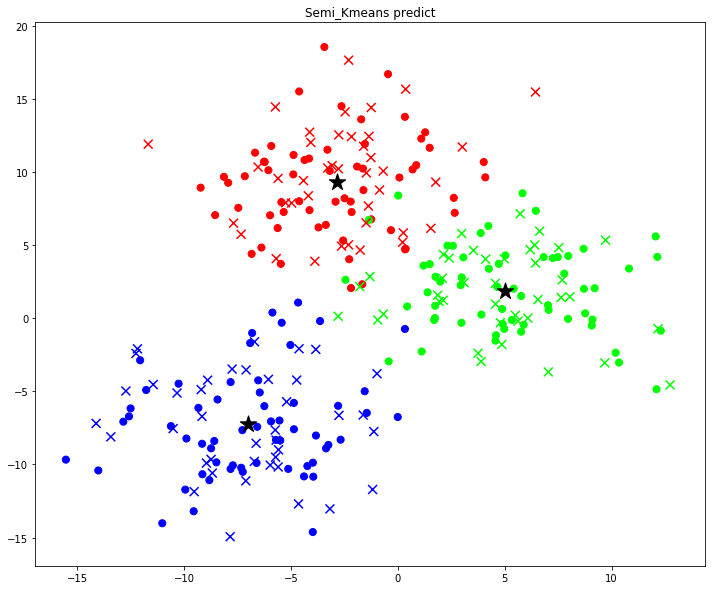

In [162]:
plt.figure(figsize=(12, 10))
ax = plt.subplot(111)
ax.scatter(X_train[:,0], X_train[:,1], c=new_label, s=50, cmap='viridis')
ax.scatter(X_test[:,0], X_test[:,1], c=Pred_label, marker='x', s=80, cmap='viridis')
ax.scatter(Ctrd[:,0], Ctrd[:,1], marker="*", c='k', s =300)
ax.set_title('Semi_Kmeans predict')
plt.show()

In [163]:
# Semi_GMM
Semi = Semi_Supervised(3, 2)
class_num = Semi.cluster
pi = np.array([[p1],[p2],[p3]])
mu = Ctrd
sigma = [var_C1, var_C2, var_C3]
#ite, pi, mu, sigma, Fun_vals
ite, pi, mu, sigma, Fun_vals = Semi.Semi_GmmTrain(X_train, y_train, X_test, pi, mu, sigma)
print('the number of iteration in GMM is:', ite)
Gmm_Pred_label = Semi.Gmm_predict(X_test, pi, mu, sigma)

# The prediction accuracy 
New_test_label = Semi.OldLabel_to_newLabel(y_test)
k = 0
for i in range(len(New_test_label)):
    if LA.norm(New_test_label[i,:]-Gmm_Pred_label[i,:]) == 0:
        k = k+1
acc = k/len(New_test_label)

print("the prediction accuracy is: ", acc)

the number of iteration in GMM is: 15
the prediction accuracy is:  0.9333333333333333


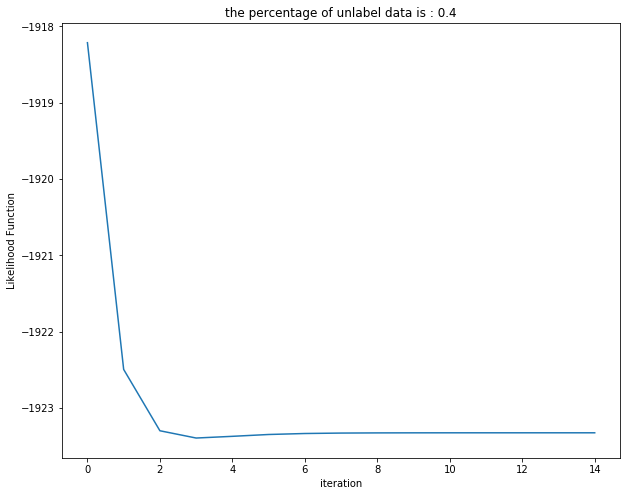

In [164]:
plt.figure(figsize=(10, 8))
plt.plot(range(ite), np.reshape(Fun_vals, [len(Fun_vals),1]))
plt.xlabel('iteration')
plt.ylabel('Likelihood Function')
plt.title("the percentage of unlabel data is : {}".format(unlabelpre))

plt.show()

It look like very strange because the likelihood function look like decreasing. The reason is the unlabel data is to small. The likelihood will increasing when we increase the percentage .

<table>
<td> 
<img src="unlabel=0.1.png" style="width:500;height:500px;"> <br>
</td> 
<td> 
<img src="unlabel=0.4.png" style="width:500;height:500px;"> <br>
</td> 
</table>
<table>
<td> 
<img src="unlabel=0.7.png" style="width:500;height:500px;"> <br>
</td> 
<td> 
<img src="unlabel=0.9.png" style="width:500;height:500px;"> <br>
</td> 
</table>

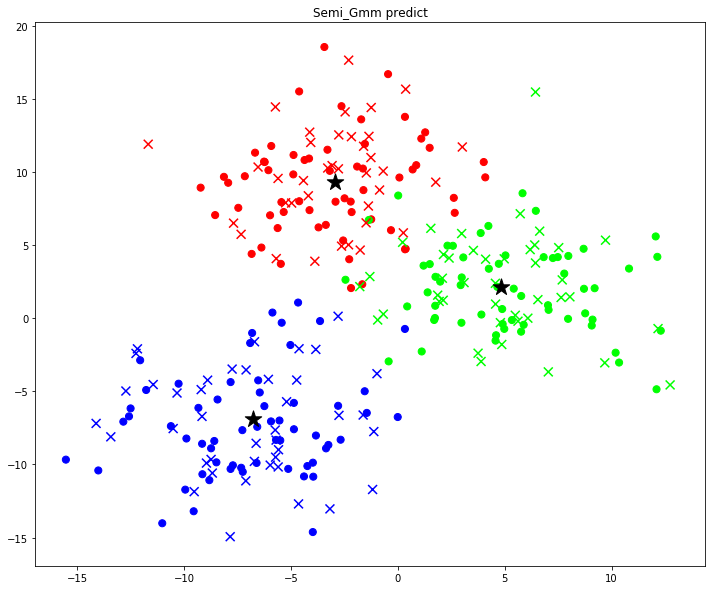

In [165]:
plt.figure(figsize=(12, 10))
ax = plt.subplot(111)
ax.scatter(X_train[:,0], X_train[:,1], c=new_label, s=50, cmap='viridis')
ax.scatter(X_test[:,0], X_test[:,1], c=Gmm_Pred_label, marker='x', s=80, cmap='viridis')
ax.scatter(mu[:,0], mu[:,1], marker="*", c='k', s =300)
ax.set_title('Semi_Gmm predict')
plt.show()